In [1]:
import os
import glob
import pickle
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import binary_dilation, binary_erosion
from skimage.transform import resize
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras_unet_collection import models
from tensorflow import keras
from keras_unet_collection.utils import dummy_loader
import cv2
import gc

import os
import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import binary_dilation, binary_erosion
from skimage.transform import resize
import tensorflow as tf
import os
from PIL import Image

import sys
sys.path.append('cloth3d')
sys.path.append('cloth3d/DataReader')
sys.path.append('cloth3d/DataReader/smpl')

from cloth3d.DataReader.read import DataReader
from cloth3d.DataReader.depth_render import Render
from cloth3d.DataReader.util import intrinsic, extrinsic

# Path to data
SRC = 'cloth3d++_subset/'
print('SRC:', SRC)

N_TRAIN = 128
N_VAL = 16

n_epochs = 20
batch_size = 4


2024-05-22 20:36:38.961519: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-22 20:36:39.012904: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-22 20:36:39.012953: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-22 20:36:39.013000: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-22 20:36:39.023364: I tensorflow/core/platform/cpu_feature_g

SRC: cloth3d++_subset/


In [2]:
class TFRecordDataHandler:
    def __init__(self, tfrecord_file, batch_size=32, shuffle=True, augment=False):
        self.tfrecord_file = tfrecord_file
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment

    def _parse_function(self, proto):
        feature_description = {
            'image': tf.io.FixedLenFeature([], tf.string),
            'depth': tf.io.FixedLenFeature([], tf.string),
            'height': tf.io.FixedLenFeature([], tf.int64),
            'width': tf.io.FixedLenFeature([], tf.int64),
            'depth_height': tf.io.FixedLenFeature([], tf.int64),
            'depth_width': tf.io.FixedLenFeature([], tf.int64)
        }
        parsed_features = tf.io.parse_single_example(proto, feature_description)
        
        image = tf.io.decode_raw(parsed_features['image'], tf.uint8)
        depth = tf.io.decode_raw(parsed_features['depth'], tf.float32)
        
        height = parsed_features['height']
        width = parsed_features['width']
        
        image = tf.reshape(image, [height, width, 3])
        depth = tf.reshape(depth, [parsed_features['depth_height'], parsed_features['depth_width']])
        
        return image, depth

    def _normalize(self, image, depth):
        # Convert image to float for processing and normalize to range [0, 1]
        image = tf.cast(image, tf.float32) / 255.0

        # Create a mask where depth values are greater than zero
        depth_mask = depth > 0

        # Normalize depth based on masked regions
        # Calculate the mean of the depth where it is greater than zero
        depth_values = tf.boolean_mask(depth, depth_mask)
        depth_mean = tf.reduce_mean(depth_values)

        # Subtract the mean from the depth values where mask is true
        depth = tf.where(depth_mask, depth - depth_mean, depth)

        # Set depth values less than 0 to 0 after subtraction
        depth = tf.maximum(depth, 0)

        # Prepare the mask for RGB image normalization
        mask = tf.tile(tf.expand_dims(depth_mask, axis=-1), [1, 1, 3])

        # Masked image for mean and std deviation calculation
        masked_image = tf.boolean_mask(image, mask)
        mean, variance = tf.nn.moments(masked_image, axes=[0])
        std_dev = tf.sqrt(variance + 1e-6)  # Adding epsilon to avoid division by zero

        # Apply the mask to image normalization
        normalized_image = tf.where(
            mask,
            (image - mean) / std_dev,
            image  # Preserve original pixels where mask is False
        )

        return normalized_image, depth

    def _augment(self, image, depth):
        if tf.random.uniform(()) > 0.5:
            image = tf.image.flip_left_right(image)
            depth = tf.image.flip_left_right(tf.expand_dims(depth, axis=-1))
            depth = tf.squeeze(depth, axis=-1)
        image = tf.image.random_brightness(image, max_delta=0.1)
        return image, depth

    def load_dataset(self):
        dataset = tf.data.TFRecordDataset(self.tfrecord_file)
        dataset = dataset.map(self._parse_function, num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.map(self._normalize, num_parallel_calls=tf.data.AUTOTUNE)

        if self.augment:
            dataset = dataset.map(self._augment, num_parallel_calls=tf.data.AUTOTUNE)

        if self.shuffle:
            dataset = dataset.shuffle(buffer_size=1000)

        dataset = dataset.batch(self.batch_size)
        dataset = dataset.prefetch(tf.data.AUTOTUNE)
        return dataset


In [3]:
class LearningRateLogger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.lr
        if isinstance(lr, tf.keras.optimizers.schedules.LearningRateSchedule):
            lr = lr(self.model.optimizer.iterations)
        print(f"Epoch {epoch + 1}: Learning rate is {tf.keras.backend.get_value(lr):.6f}")

class TensorBoardLearningRateLogger(tf.keras.callbacks.Callback):
    def __init__(self, log_dir='./logs'):
        super(TensorBoardLearningRateLogger, self).__init__()
        self.file_writer = tf.summary.create_file_writer(log_dir)

    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.lr
        if isinstance(lr, tf.keras.optimizers.schedules.LearningRateSchedule):
            lr = lr(self.model.optimizer.iterations)
        with self.file_writer.as_default():
            tf.summary.scalar('learning_rate', tf.keras.backend.get_value(lr), step=epoch)

In [4]:
def visualize_hist(history, show=True, filename=None, title='Training history'):
    train_hist = history.history

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
    fig.suptitle(title, fontsize=14, fontweight='bold')

    ax1.plot(train_hist['loss'])
    ax1.plot(train_hist['val_loss'])
    ax1.set(xlabel='epoch', ylabel='Loss')
    ax1.legend(['train', 'valid'], loc='upper right')

    ax2.plot(train_hist['mae'])
    ax2.plot(train_hist['val_mae'])
    ax2.set(xlabel='epoch', ylabel='MAE')
    ax2.legend(['train', 'valid'], loc='upper right')

    if show:
        plt.show()

    if filename is not None:
        fig.savefig(filename)

In [5]:
# Hide GPU 0 (usually the one with the most memory) from TensorFlow. Use only GPU 1 and 2.
os.environ["CUDA_VISIBLE_DEVICES"] = "1,2"

2024-05-22 20:36:41.093347: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10792 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:86:00.0, compute capability: 8.6
2024-05-22 20:36:41.094369: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 11395 MB memory:  -> device: 1, name: NVIDIA TITAN Xp, pci bus id: 0000:18:00.0, compute capability: 6.1


(5, 256, 256, 3) (5, 256, 256)


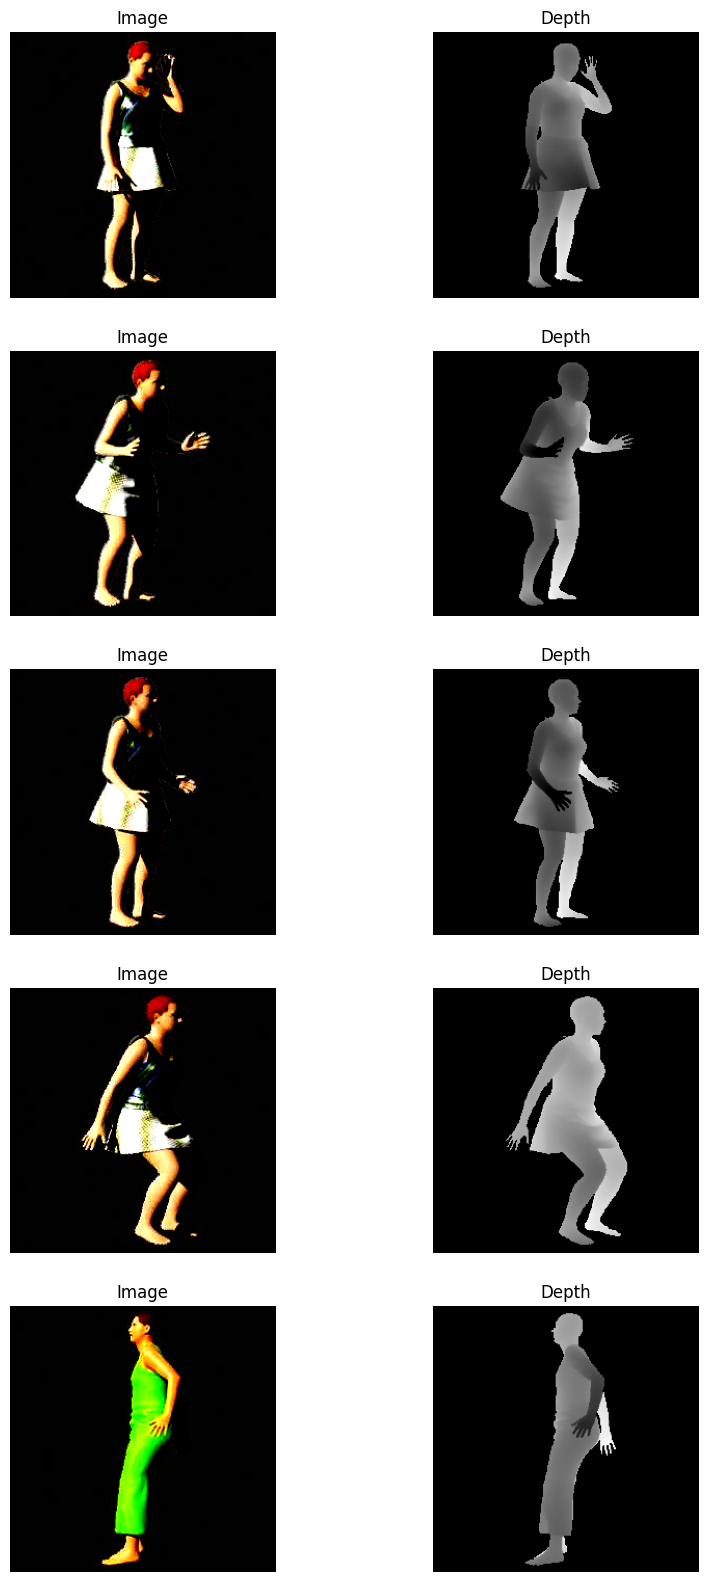

In [6]:
import matplotlib.pyplot as plt

def visualize_data(images, depths, num_samples=5):
    plt.figure(figsize=(10, num_samples * 4))  # Adjusted for better visualization layout
    for i in range(num_samples):
        plt.subplot(num_samples, 2, 2 * i + 1)
        # Clip the image data to ensure it's within the valid range
        plt.imshow(np.clip(images[i], 0, 1))
        plt.title("Image")
        plt.axis('off')
        
        plt.subplot(num_samples, 2, 2 * i + 2)
        # For depth, ensure it is normalized or adjust accordingly
        plt.imshow(depths[i], cmap='gray')
        plt.title("Depth")
        plt.axis('off')
    plt.show()


# Carga algunos datos de ambos métodos
handler = TFRecordDataHandler('train.tfrecords', batch_size=5, shuffle=False, augment=False)
dataset = handler.load_dataset()
images_tf, depths_tf = next(iter(dataset))

print(images_tf.shape, depths_tf.shape)
# Visualiza los datos de ambos métodos
visualize_data(images_tf, depths_tf, num_samples=5)


In [7]:
import tensorflow as tf

class CustomDepthLoss(tf.keras.losses.Loss):
    def __init__(self, ssim_loss_weight, l1_loss_weight, edge_loss_weight, **kwargs):
        super(CustomDepthLoss, self).__init__(**kwargs)
        self.ssim_loss_weight = ssim_loss_weight
        self.l1_loss_weight = l1_loss_weight
        self.edge_loss_weight = edge_loss_weight

    def call(self, target, pred):
         # Ensure target and pred have the shape [batch_size, height, width, channels]
        if len(target.shape) == 3:
            target = tf.expand_dims(target, axis=-1)
        if len(pred.shape) == 3:
            pred = tf.expand_dims(pred, axis=-1)

        if target.shape[-1] != 1:
            raise ValueError(f"Expected target to have 1 channel, but got {target.shape[-1]} channels")
        if pred.shape[-1] != 1:
            raise ValueError(f"Expected pred to have 1 channel, but got {pred.shape[-1]} channels")

        # print shape of target and pred
        # Edges
        dy_true, dx_true = tf.image.image_gradients(target)
        dy_pred, dx_pred = tf.image.image_gradients(pred)
        weights_x = tf.exp(tf.reduce_mean(tf.abs(dx_true)))
        weights_y = tf.exp(tf.reduce_mean(tf.abs(dy_true)))

        # Depth smoothness
        smoothness_x = dx_pred * weights_x
        smoothness_y = dy_pred * weights_y

        depth_smoothness_loss = tf.reduce_mean(tf.abs(smoothness_x)) + tf.reduce_mean(tf.abs(smoothness_y))

        # Structural similarity (SSIM) index
        ssim_loss = tf.reduce_mean(1 - tf.image.ssim(target, pred, max_val=tf.reduce_max(target), filter_size=7, k1=0.01 ** 2, k2=0.03 ** 2))

        # Point-wise depth
        l1_loss = tf.reduce_mean(tf.abs(target - pred))

        loss = (self.ssim_loss_weight * ssim_loss) + (self.l1_loss_weight * l1_loss) + (self.edge_loss_weight * depth_smoothness_loss)

        return loss


# Experiment: Losses

In [8]:
class WarmUpCosineDecayScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_learning_rate, target_learning_rate, total_steps, warmup_steps):
        super(WarmUpCosineDecayScheduler, self).__init__()
        self.initial_learning_rate = initial_learning_rate
        self.target_learning_rate = target_learning_rate
        self.total_steps = total_steps
        self.warmup_steps = warmup_steps
        self.decay_steps = total_steps - warmup_steps

    def __call__(self, step):
        # Convert to float32 to ensure the operations are compatible
        step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        decay_steps = tf.cast(self.decay_steps, tf.float32)
        
        # Compute the warmup learning rate
        warmup_lr = self.initial_learning_rate + (self.target_learning_rate - self.initial_learning_rate) * (step / warmup_steps)
        
        # Compute the cosine decay learning rate
        cosine_decay = 0.5 * (1 + tf.cos(np.pi * (step - warmup_steps) / decay_steps))
        decayed_lr = (self.target_learning_rate - self.initial_learning_rate) * cosine_decay + self.initial_learning_rate
        
        # Choose the learning rate based on the step
        learning_rate = tf.where(step < warmup_steps, warmup_lr, decayed_lr)
        return learning_rate

    def get_config(self):
        return {
            'initial_learning_rate': self.initial_learning_rate,
            'target_learning_rate': self.target_learning_rate,
            'total_steps': self.total_steps,
            'warmup_steps': self.warmup_steps
        }


Number of data used to train:
Train: 372

Training model with l1_loss_weight=1, ssim_loss_weight=0, smooth_loss_weight=0


2024-05-22 20:36:43.996856: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Epoch 1/20


2024-05-22 20:36:53.090832: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2024-05-22 20:36:53.225717: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-22 20:36:55.059910: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fd2953e1a50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-22 20:36:55.059953: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-05-22 20:36:55.059960: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA TITAN Xp, Compute Capability 6.1
2024-05-22 20:36:55.065551: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-22 20:36:55.147273: I ./tensorflow/compiler/jit/devic

      6/Unknown - 19s 115ms/step - loss: 0.4807 - mae: 0.4807WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0564s vs `on_train_batch_end` time: 0.0732s). Check your callbacks.
     93/Unknown - 29s 116ms/step - loss: 0.1676 - mae: 0.1676

2024-05-22 20:37:13.409125: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3632327781841774951
2024-05-22 20:37:13.409172: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15216146085271132656
2024-05-22 20:37:13.409185: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16241623035553043205


93/93 [==============================] - 31s 142ms/step - loss: 0.1676 - mae: 0.1676 - val_loss: 0.9399 - val_mae: 0.9399
Epoch 2/20


2024-05-22 20:37:15.772842: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7121678556562697564


93/93 [==============================] - 12s 127ms/step - loss: 0.0470 - mae: 0.0470 - val_loss: 0.4275 - val_mae: 0.4275
Epoch 3/20
93/93 [==============================] - 12s 129ms/step - loss: 0.0327 - mae: 0.0327 - val_loss: 0.4533 - val_mae: 0.4533
Epoch 4/20
93/93 [==============================] - 12s 127ms/step - loss: 0.0280 - mae: 0.0280 - val_loss: 0.0350 - val_mae: 0.0350
Epoch 5/20
93/93 [==============================] - 12s 129ms/step - loss: 0.0279 - mae: 0.0279 - val_loss: 0.0325 - val_mae: 0.0325
Epoch 6/20
93/93 [==============================] - 12s 129ms/step - loss: 0.0269 - mae: 0.0269 - val_loss: 0.0333 - val_mae: 0.0333
Epoch 7/20
93/93 [==============================] - 12s 127ms/step - loss: 0.0261 - mae: 0.0261 - val_loss: 0.0314 - val_mae: 0.0314
Epoch 8/20
93/93 [==============================] - 12s 128ms/step - loss: 0.0263 - mae: 0.0263 - val_loss: 0.0316 - val_mae: 0.0316
Epoch 9/20
93/93 [==============================] - 12s 127ms/step - loss: 0.025

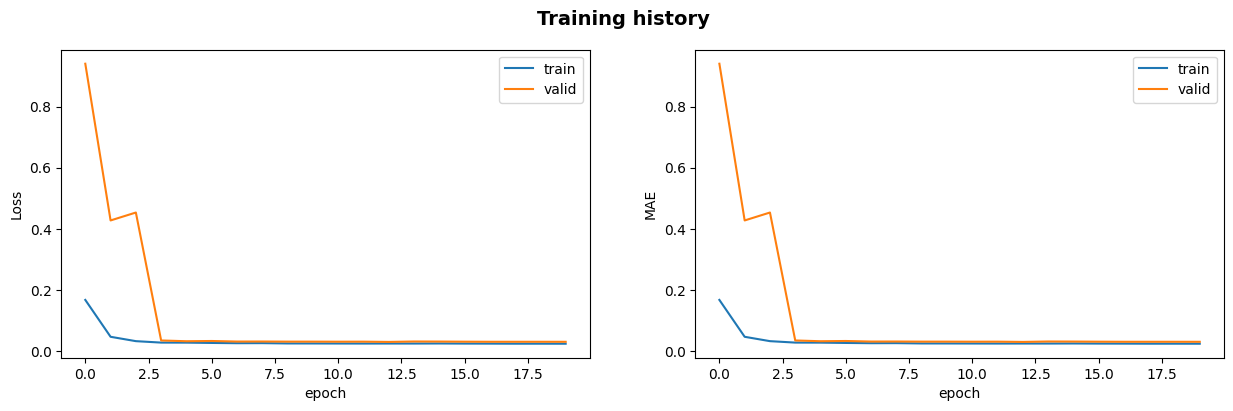

Best validation loss: 0.030236784368753433 at epoch 12
Training model with l1_loss_weight=1, ssim_loss_weight=1, smooth_loss_weight=0
Epoch 1/20
      6/Unknown - 13s 114ms/step - loss: 1.3833 - mae: 0.3839WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0538s vs `on_train_batch_end` time: 0.0720s). Check your callbacks.
93/93 [==============================] - 25s 139ms/step - loss: 1.2487 - mae: 0.2593 - val_loss: 1.9063 - val_mae: 0.9399
Epoch 2/20


2024-05-22 20:41:32.000123: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10399213787756237585
2024-05-22 20:41:32.000164: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13472564251958642447


93/93 [==============================] - 12s 127ms/step - loss: 1.2383 - mae: 0.2463 - val_loss: 1.4445 - val_mae: 0.4876
Epoch 3/20
93/93 [==============================] - 12s 127ms/step - loss: 1.2946 - mae: 0.3024 - val_loss: 1.3009 - val_mae: 0.3260
Epoch 4/20
93/93 [==============================] - 12s 127ms/step - loss: 1.2823 - mae: 0.2938 - val_loss: 1.3151 - val_mae: 0.3255
Epoch 5/20
93/93 [==============================] - 12s 127ms/step - loss: 1.2839 - mae: 0.2877 - val_loss: 1.2983 - val_mae: 0.2998
Epoch 6/20
93/93 [==============================] - 12s 127ms/step - loss: 1.2761 - mae: 0.2813 - val_loss: 1.2527 - val_mae: 0.2640
Epoch 7/20
93/93 [==============================] - 12s 127ms/step - loss: 1.3242 - mae: 0.3323 - val_loss: 1.2066 - val_mae: 0.2177
Epoch 8/20
93/93 [==============================] - 12s 127ms/step - loss: 1.3531 - mae: 0.3623 - val_loss: 1.1801 - val_mae: 0.1976
Epoch 9/20
93/93 [==============================] - 12s 129ms/step - loss: 1.344

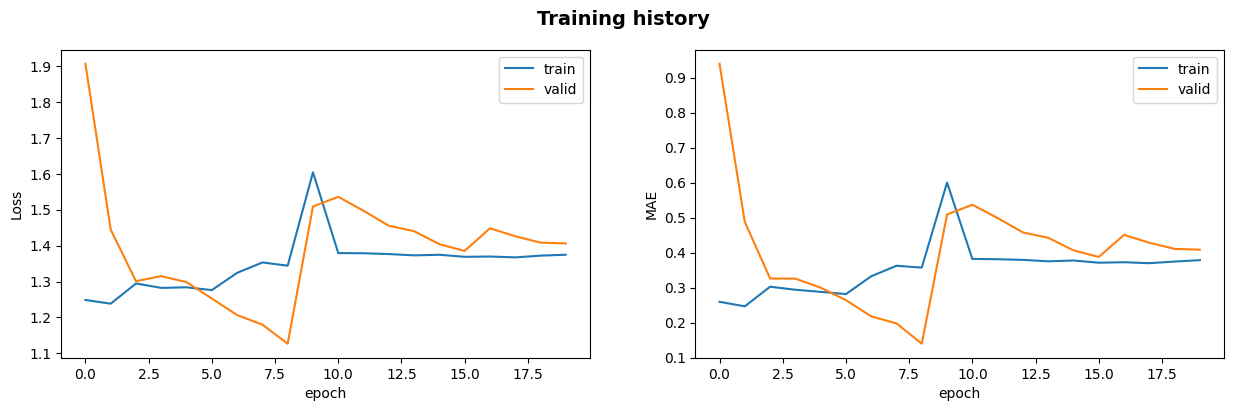

Best validation loss: 1.126893401145935 at epoch 8
Training model with l1_loss_weight=1, ssim_loss_weight=0, smooth_loss_weight=1
Epoch 1/20
      6/Unknown - 12s 113ms/step - loss: 0.5007 - mae: 0.4213WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0547s vs `on_train_batch_end` time: 0.0698s). Check your callbacks.
     93/Unknown - 22s 114ms/step - loss: 0.1918 - mae: 0.1723

2024-05-22 20:45:45.246871: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15216146085271132656


93/93 [==============================] - 24s 138ms/step - loss: 0.1918 - mae: 0.1723 - val_loss: 0.9399 - val_mae: 0.9399
Epoch 2/20


2024-05-22 20:45:47.345165: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13472564251958642447


93/93 [==============================] - 12s 126ms/step - loss: 0.0531 - mae: 0.0446 - val_loss: 0.0610 - val_mae: 0.0604
Epoch 3/20
93/93 [==============================] - 12s 128ms/step - loss: 0.0362 - mae: 0.0307 - val_loss: 0.0454 - val_mae: 0.0369
Epoch 4/20
93/93 [==============================] - 12s 126ms/step - loss: 0.0338 - mae: 0.0284 - val_loss: 0.0409 - val_mae: 0.0352
Epoch 5/20
93/93 [==============================] - 12s 128ms/step - loss: 0.0327 - mae: 0.0273 - val_loss: 0.0485 - val_mae: 0.0441
Epoch 6/20
93/93 [==============================] - 12s 129ms/step - loss: 0.0326 - mae: 0.0274 - val_loss: 0.0387 - val_mae: 0.0326
Epoch 7/20
93/93 [==============================] - 12s 126ms/step - loss: 0.0318 - mae: 0.0265 - val_loss: 0.0390 - val_mae: 0.0330
Epoch 8/20
93/93 [==============================] - 12s 129ms/step - loss: 0.0313 - mae: 0.0262 - val_loss: 0.0391 - val_mae: 0.0341
Epoch 9/20
93/93 [==============================] - 12s 126ms/step - loss: 0.030

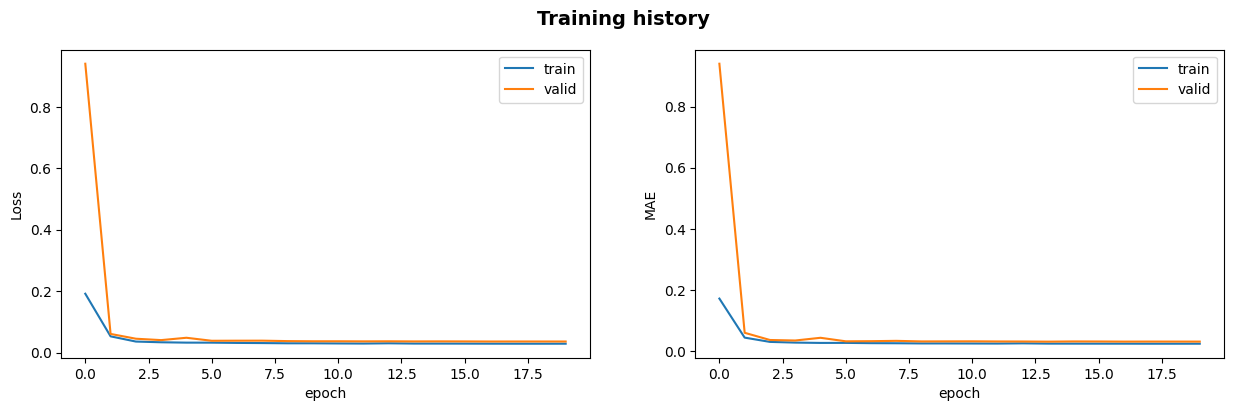

Best validation loss: 0.03634937107563019 at epoch 16
Training model with l1_loss_weight=1, ssim_loss_weight=1, smooth_loss_weight=1
Epoch 1/20
      6/Unknown - 13s 114ms/step - loss: 1.5565 - mae: 0.4297WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0557s vs `on_train_batch_end` time: 0.0718s). Check your callbacks.
93/93 [==============================] - 25s 140ms/step - loss: 1.4661 - mae: 0.3576 - val_loss: 1.4519 - val_mae: 0.3215
Epoch 2/20


2024-05-22 20:50:03.894489: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10399213787756237585
2024-05-22 20:50:03.894539: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13472564251958642447


93/93 [==============================] - 12s 127ms/step - loss: 1.2889 - mae: 0.2410 - val_loss: 1.5414 - val_mae: 0.5018
Epoch 3/20
93/93 [==============================] - 12s 128ms/step - loss: 1.2225 - mae: 0.2004 - val_loss: 0.6427 - val_mae: 0.0691
Epoch 4/20
93/93 [==============================] - 12s 128ms/step - loss: 1.8620 - mae: 0.8603 - val_loss: 0.3740 - val_mae: 0.0875
Epoch 5/20
93/93 [==============================] - 12s 128ms/step - loss: 1.8377 - mae: 0.7660 - val_loss: 1.3235 - val_mae: 0.3971
Epoch 6/20
93/93 [==============================] - 12s 128ms/step - loss: 1.2261 - mae: 0.3064 - val_loss: 1.9143 - val_mae: 0.9325
Epoch 7/20
93/93 [==============================] - 12s 128ms/step - loss: 1.1435 - mae: 0.2982 - val_loss: 0.7519 - val_mae: 0.3096
Epoch 8/20
93/93 [==============================] - 12s 127ms/step - loss: 0.9281 - mae: 0.3389 - val_loss: 0.7834 - val_mae: 0.3005
Epoch 9/20
93/93 [==============================] - 12s 127ms/step - loss: 0.915

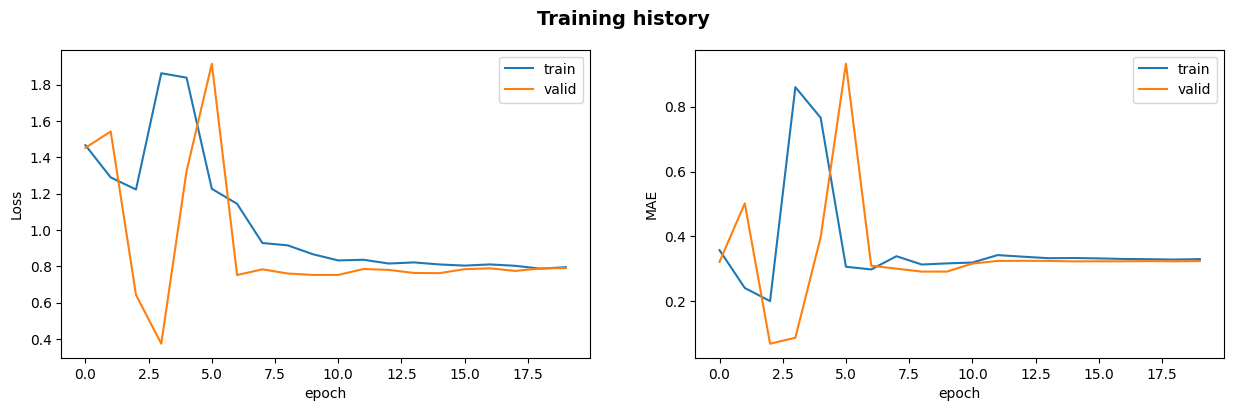

Best validation loss: 0.3740496337413788 at epoch 3
Training model with l1_loss_weight=0.1, ssim_loss_weight=0.85, smooth_loss_weight=0.9
Epoch 1/20
      6/Unknown - 12s 114ms/step - loss: 0.9794 - mae: 0.4155WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0547s vs `on_train_batch_end` time: 0.0728s). Check your callbacks.
93/93 [==============================] - 24s 138ms/step - loss: 0.9467 - mae: 0.4718 - val_loss: 1.0611 - val_mae: 0.4889
Epoch 2/20


2024-05-22 20:54:20.465446: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10399213787756237585


93/93 [==============================] - 12s 126ms/step - loss: 0.9325 - mae: 0.3967 - val_loss: 0.9305 - val_mae: 0.2959
Epoch 3/20
93/93 [==============================] - 12s 127ms/step - loss: 0.9063 - mae: 0.1930 - val_loss: 0.1921 - val_mae: 0.0602
Epoch 4/20
93/93 [==============================] - 12s 127ms/step - loss: 0.8626 - mae: 0.1215 - val_loss: 0.8041 - val_mae: 0.1100
Epoch 5/20
93/93 [==============================] - 12s 128ms/step - loss: 0.8807 - mae: 0.2077 - val_loss: 0.3676 - val_mae: 0.0612
Epoch 6/20
93/93 [==============================] - 12s 128ms/step - loss: 0.8644 - mae: 0.2774 - val_loss: 0.5919 - val_mae: 0.1420
Epoch 7/20
93/93 [==============================] - 12s 127ms/step - loss: 0.8402 - mae: 0.3917 - val_loss: 0.7001 - val_mae: 0.2121
Epoch 8/20
93/93 [==============================] - 12s 127ms/step - loss: 0.8351 - mae: 0.4049 - val_loss: 0.8026 - val_mae: 0.2771
Epoch 9/20
93/93 [==============================] - 12s 127ms/step - loss: 0.833

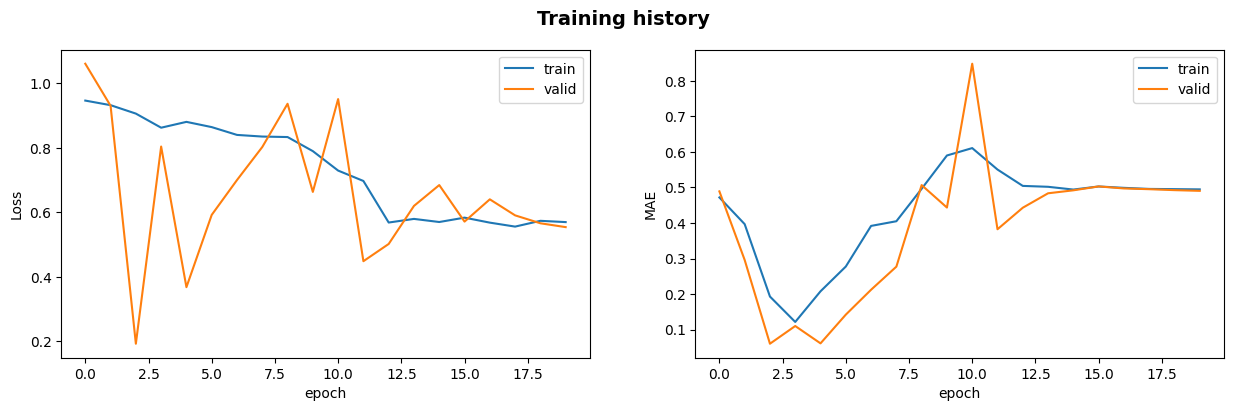

Best validation loss: 0.19209665060043335 at epoch 2


In [9]:
# Training
# hyperparameters
checkpoint = './best_model.h5'
shuffle = True
verbose = 1

# creating data generators to load the data
train_dg = TFRecordDataHandler('train.tfrecords', batch_size=batch_size, shuffle=shuffle, augment=True).load_dataset()
validation_dg = TFRecordDataHandler('validation.tfrecords', batch_size=batch_size, shuffle=shuffle, augment=False).load_dataset()
print('Number of data used to train:')
print('Train:', len(list(train_dg) * batch_size))
print('')

total_steps = len(list(train_dg)) * n_epochs
initial_learning_rate = 1e-5
target_learning_rate = 1e-2

# l1, ssim, edge
values_losses = [
    (1, 0, 0),
    (1, 1, 0),
    (1, 0, 1),
    (1, 1, 1),
    (0.1, 0.85, 0.9)
]

warmup_steps = int(0.1 * total_steps)

lr_schedule = WarmUpCosineDecayScheduler(
        initial_learning_rate=initial_learning_rate,
        target_learning_rate=target_learning_rate,
        total_steps=total_steps,
        warmup_steps=warmup_steps
    )

results = []
for index, (l1_loss_weight, ssim_loss_weight, smooth_loss_weight) in enumerate(values_losses):

    # Create model
    model = models.unet_2d((256, 256, 3), [64, 128, 256, 512, 1024], n_labels=1,
                        stack_num_down=2, stack_num_up=1,
                        activation='GELU', output_activation='Sigmoid', 
                        batch_norm=True, pool='max', unpool=False, name='unet')

    print(f"Training model with l1_loss_weight={l1_loss_weight}, ssim_loss_weight={ssim_loss_weight}, smooth_loss_weight={smooth_loss_weight}")

    experiment_name = f"l1_{l1_loss_weight}_ssim_{ssim_loss_weight}_smooth_{smooth_loss_weight}"

    # TensorBoard callback
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=os.path.join('./logs', experiment_name))

    # TensorBoard learning rate logger callback
    tensorboard_lr_logger = TensorBoardLearningRateLogger(log_dir=os.path.join('./logs', experiment_name))
    
    # defining the optimizer
    custom_loss_criterion = CustomDepthLoss(ssim_loss_weight, l1_loss_weight, smooth_loss_weight)
    model.compile(tf.keras.optimizers.Adam(learning_rate=lr_schedule), loss=custom_loss_criterion, metrics=['mae'])

    # es = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=3)

    # saving the best model based on val_loss
    # mc = tf.keras.callbacks.ModelCheckpoint(checkpoint, monitor='val_mae', mode='min', save_best_only=True, save_freq=5)

    # training the model and saving the history
    history = model.fit(train_dg, validation_data=validation_dg, epochs=n_epochs, verbose=verbose, workers=8, 
                        callbacks=[tensorboard_callback, tensorboard_lr_logger])

    # Plot and write the history
    if not os.path.exists(experiment_name):
        os.makedirs(experiment_name)
    filename = os.path.join(experiment_name, 'train_history.png')
    visualize_hist(history, show=True, filename=filename)
    
    #with open('train_history_lr_'+str(lr)+'.pkl', 'wb') as handle:
    #    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
    # Get the best validation loss and the epoch

    best_val_loss = min(history.history['val_loss'])
    best_epoch = history.history['val_loss'].index(best_val_loss)
    results.append((ssim_loss_weight, l1_loss_weight, smooth_loss_weight, best_val_loss, best_epoch))
    print('Best validation loss:', best_val_loss, 'at epoch', best_epoch)

    # Clear gpu memory
    del model
    gc.collect()
    tf.keras.backend.clear_session()
    
#with open('train_history.pkl', 'wb') as handle:
 #   pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)